Import modules and dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix, roc_curve, auc

from sklearn import discriminant_analysis as da
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Binarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, accuracy_score

from scipy.special import expit
import seaborn as sns

In [5]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Global YouTube Statistics.csv'
df = pd.read_csv(path, encoding='latin1')
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,rank,Youtuber,subscribers,video views,category,Title,uploads,Country,Abbreviation,channel_type,...,subscribers_for_last_30_days,created_year,created_month,created_date,Gross tertiary education enrollment (%),Population,Unemployment rate,Urban_population,Latitude,Longitude
0,1,T-Series,245000000,2.280000e+11,Music,T-Series,20082,India,IN,Music,...,2000000.0,2006.0,Mar,13.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880
1,2,YouTube Movies,170000000,0.000000e+00,Film & Animation,youtubemovies,1,United States,US,Games,...,NaN,2006.0,Mar,5.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891
2,3,MrBeast,166000000,2.836884e+10,Entertainment,MrBeast,741,United States,US,Entertainment,...,8000000.0,2012.0,Feb,20.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891
3,4,Cocomelon - Nursery Rhymes,162000000,1.640000e+11,Education,Cocomelon - Nursery Rhymes,966,United States,US,Education,...,1000000.0,2006.0,Sep,1.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891
4,5,SET India,159000000,1.480000e+11,Shows,SET India,116536,India,IN,Entertainment,...,1000000.0,2006.0,Sep,20.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,991,Natan por Aï¿,12300000,9.029610e+09,Sports,Natan por Aï¿,1200,Brazil,BR,Entertainment,...,700000.0,2017.0,Feb,12.0,51.3,2.125594e+08,12.08,183241641.0,-14.235004,-51.925280
991,992,Free Fire India Official,12300000,1.674410e+09,People & Blogs,Free Fire India Official,1500,India,IN,Games,...,300000.0,2018.0,Sep,14.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880
992,993,Panda,12300000,2.214684e+09,NaN,HybridPanda,2452,United Kingdom,GB,Games,...,1000.0,2006.0,Sep,11.0,60.0,6.683440e+07,3.85,55908316.0,55.378051,-3.435973
993,994,RobTopGames,12300000,3.741235e+08,Gaming,RobTopGames,39,Sweden,SE,Games,...,100000.0,2012.0,May,9.0,67.0,1.028545e+07,6.48,9021165.0,60.128161,18.643501


Module 1: Data Preprocessing

In [6]:
#The first thing is to get rid of any 0 uploading values because they will mess up the data.
# The reason these value will mess up the prediction as 0 uploads should = 0 views.
# However, this is not the case because YT makes their own accounts that are considered channels but do not actually post.

df.loc[df['video views'] == 0, 'video views'] = np.nan
df = df.dropna(subset=['video views'])

df.loc[df['subscribers'] == 0, 'subscribers'] = np.nan
df = df.dropna(subset=['subscribers'])

# Lower bound uploads is a requirement we have made for a channel to demonstrate that they are not one-hit wonders and have dedicated time to being a YouTuber.
lower_bound_uploads = 50

df = df[df['uploads'] >= lower_bound_uploads]

# Channels of the music type are channels such as VEVO and other labels.
# We do not consider these channels as YouTubers as they only upload music videos of artists signed to them.
df = df[df['channel_type'] != 'Music']

df


,rank,Youtuber,subscribers,video views,category,Title,uploads,Country,Abbreviation,channel_type,...,subscribers_for_last_30_days,created_year,created_month,created_date,Gross tertiary education enrollment (%),Population,Unemployment rate,Urban_population,Latitude,Longitude
2,3,MrBeast,166000000.0,2.836884e+10,Entertainment,MrBeast,741,United States,US,Entertainment,...,8000000.0,2012.0,Feb,20.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891
3,4,Cocomelon - Nursery Rhymes,162000000.0,1.640000e+11,Education,Cocomelon - Nursery Rhymes,966,United States,US,Education,...,1000000.0,2006.0,Sep,1.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891
4,5,SET India,159000000.0,1.480000e+11,Shows,SET India,116536,India,IN,Entertainment,...,1000000.0,2006.0,Sep,20.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880
6,7,ýýý Kids Diana Show,112000000.0,9.324704e+10,People & Blogs,ýýý Kids Diana Show,1111,United States,US,Entertainment,...,NaN,2015.0,May,12.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891
7,8,PewDiePie,111000000.0,2.905804e+10,Gaming,PewDiePie,4716,Japan,JP,Entertainment,...,NaN,2010.0,Apr,29.0,63.2,1.262266e+08,2.29,115782416.0,36.204824,138.252924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,990,Migos ATL,12400000.0,6.993406e+09,Music,Migos ATL,99,United States,US,Entertainment,...,100000.0,2012.0,Jan,17.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891
990,991,Natan por Aï¿,12300000.0,9.029610e+09,Sports,Natan por Aï¿,1200,Brazil,BR,Entertainment,...,700000.0,2017.0,Feb,12.0,51.3,2.125594e+08,12.08,183241641.0,-14.235004,-51.925280
991,992,Free Fire India Official,12300000.0,1.674410e+09,People & Blogs,Free Fire India Official,1500,India,IN,Games,...,300000.0,2018.0,Sep,14.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880
992,993,Panda,12300000.0,2.214684e+09,NaN,HybridPanda,2452,United Kingdom,GB,Games,...,1000.0,2006.0,Sep,11.0,60.0,6.683440e+07,3.85,55908316.0,55.378051,-3.435973


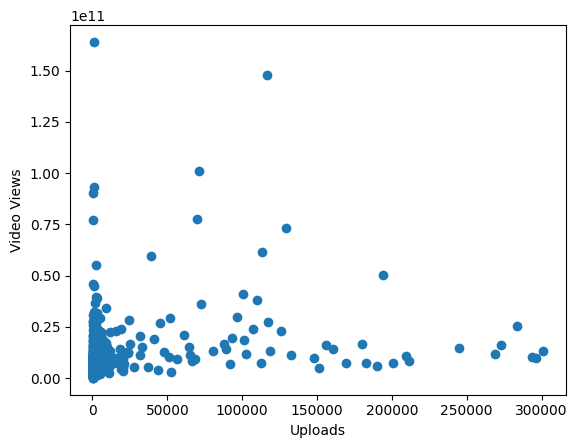

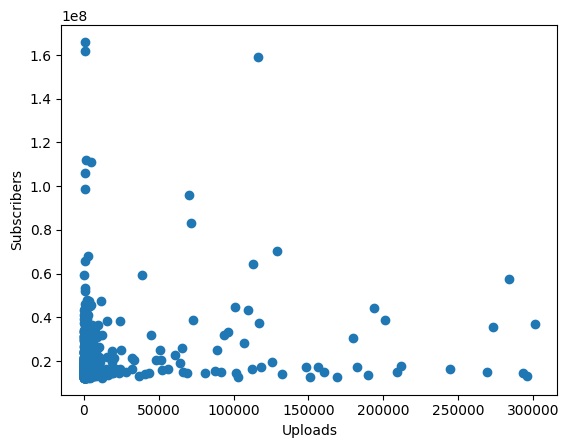

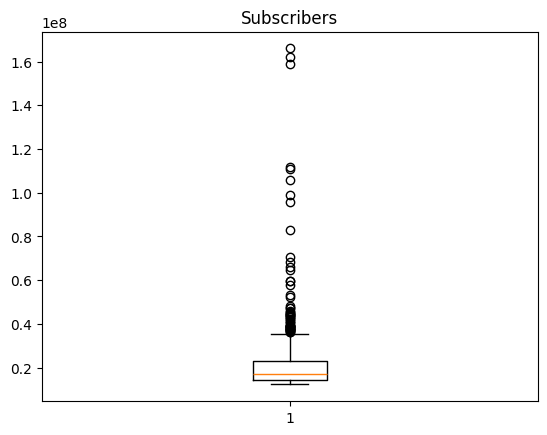

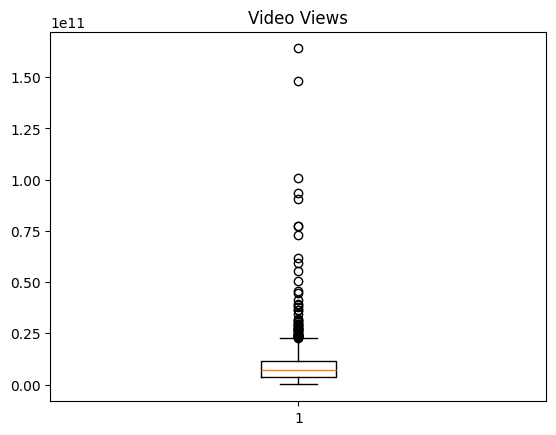

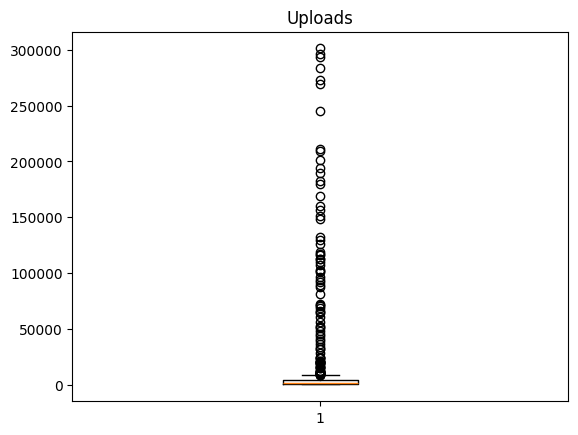

In [7]:
# Continuation of data preparations is to find the outliers and remove them from the data set.
# We will find the outliers using data visualization of box plots and performing quartile checks.
#As seen in our graphs, the video views data tends to remain below 0.8. Another observation, especially in the box plots, is the presence of numerous outliers, indicating that our data might need normalization.
plt.scatter(df['uploads'], df['video views'])
plt.xlabel('Uploads')
plt.ylabel('Video Views')
plt.show()

plt.scatter(df['uploads'], df['subscribers'])
plt.xlabel('Uploads')
plt.ylabel('Subscribers')
plt.show()

plt.boxplot(df['subscribers'])
plt.title('Subscribers')
plt.show()

plt.boxplot(df['video views'])
plt.title('Video Views')
plt.show()

plt.boxplot(df['uploads'])
plt.title('Uploads')
plt.show()


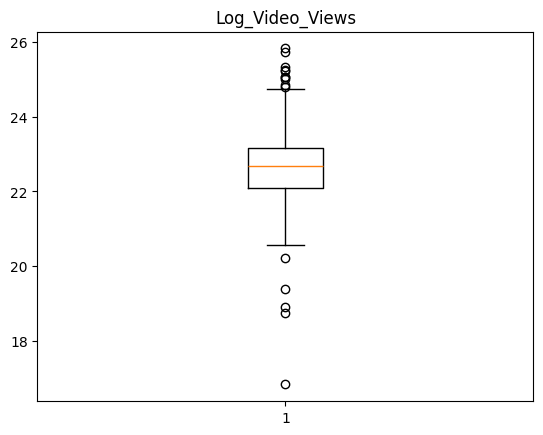

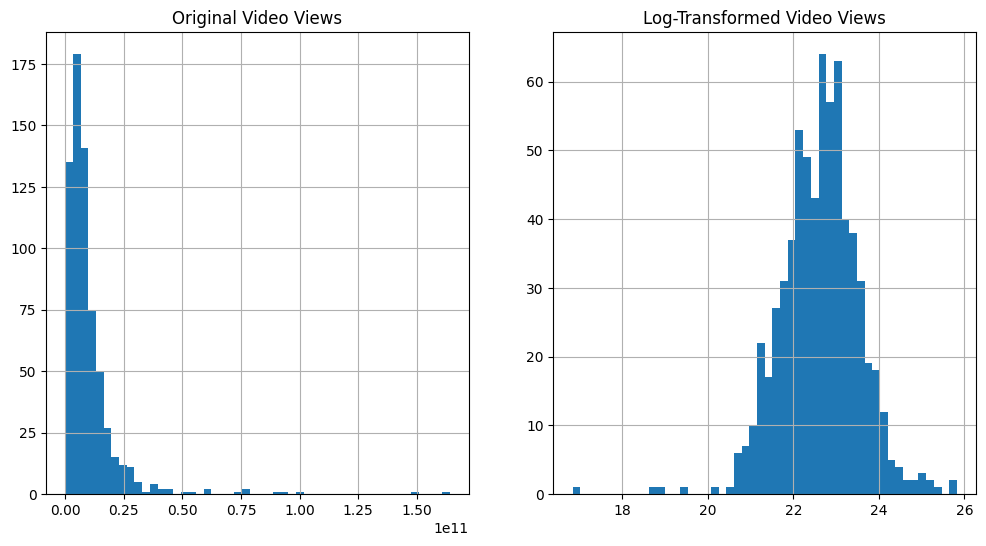

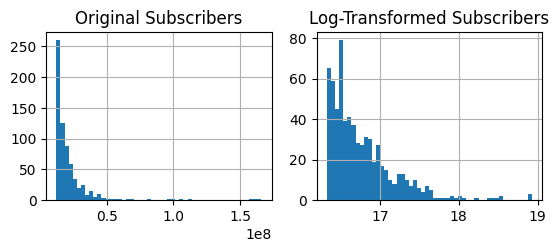

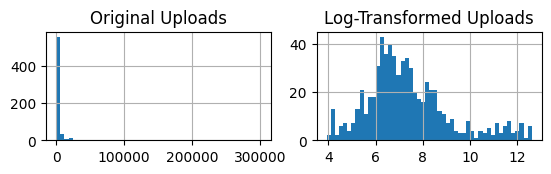

In [8]:
# Normalizing the data due to skew using log transformation
df['log_uploads'] = np.log1p(df['uploads'])
df['log_video_views'] = np.log1p(df['video views'])
df['log_subscribers'] = np.log1p(df['subscribers'])

plt.boxplot(df['log_video_views'])
plt.title('Log_Video_Views')
plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df['video views'].hist(bins=50)
plt.title("Original Video Views")

plt.subplot(1, 2, 2)
df['log_video_views'].hist(bins=50)
plt.title("Log-Transformed Video Views")

plt.show()

plt.subplot(2, 2, 1)
df['subscribers'].hist(bins=50)
plt.title("Original Subscribers")

plt.subplot(2, 2, 2)
df['log_subscribers'].hist(bins=50)
plt.title("Log-Transformed Subscribers")

plt.show()

plt.subplot(3, 2, 1)
df['uploads'].hist(bins=50)
plt.title("Original Uploads")

plt.subplot(3, 2, 2)
df['log_uploads'].hist(bins=50)
plt.title("Log-Transformed Uploads")

plt.show()

#In our graphs below we can see the difference between the amount of outliers and also the skew becoming more normal.
#However, there are still outliers so, the next step will have to be to get rid of these remaining outliers.

In [9]:
# Getting rid of all of those outliers in the data using the IQR method of removing outliers based on views.
q1 = df['log_video_views'].quantile(0.25)
q3 = df['log_video_views'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
q1, q3, iqr, lower_bound, upper_bound

(22.08586130236737,
 23.163834329956458,
 1.0779730275890884,
 20.468901760983737,
 24.78079387134009)

In [10]:
# The values that are not in the range of the lower and upper bound can be considered outliers.
# This next step is to list out the different outliers in our data.
df.loc[(df['log_video_views'] < lower_bound) | (df['log_video_views'] > upper_bound), 'log_video_views']

# Now, we will remove the outliers based on our bounds.
df = df.loc[(df['log_video_views'] >= lower_bound) & (df['log_video_views'] <= upper_bound)]
df

,rank,Youtuber,subscribers,video views,category,Title,uploads,Country,Abbreviation,channel_type,...,created_date,Gross tertiary education enrollment (%),Population,Unemployment rate,Urban_population,Latitude,Longitude,log_uploads,log_video_views,log_subscribers
2,3,MrBeast,166000000.0,2.836884e+10,Entertainment,MrBeast,741,United States,US,Entertainment,...,20.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891,6.609349,24.068557,18.927498
7,8,PewDiePie,111000000.0,2.905804e+10,Gaming,PewDiePie,4716,Japan,JP,Entertainment,...,29.0,63.2,1.262266e+08,2.29,115782416.0,36.204824,138.252924,8.458928,24.092561,18.525041
22,23,Pinkfong Baby Shark - Kids' Songs & Stories,68200000.0,3.884323e+10,Education,Pinkfong Baby Shark - Kids' Songs & Stories,2865,United States,US,Education,...,14.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891,7.960673,24.382800,18.037955
24,25,ChuChu TV Nursery Rhymes & Kids Songs,65900000.0,4.575785e+10,Education,ChuChu TV Nursery Rhymes & Kids Songs,633,India,IN,Education,...,9.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880,6.452049,24.546629,18.003649
28,29,Dude Perfect,59500000.0,1.624155e+10,Sports,Dude Perfect,389,United States,US,Sports,...,17.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891,5.966147,23.510839,17.901487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,990,Migos ATL,12400000.0,6.993406e+09,Music,Migos ATL,99,United States,US,Entertainment,...,17.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891,4.605170,22.668234,16.333207
990,991,Natan por Aï¿,12300000.0,9.029610e+09,Sports,Natan por Aï¿,1200,Brazil,BR,Entertainment,...,12.0,51.3,2.125594e+08,12.08,183241641.0,-14.235004,-51.925280,7.090910,22.923775,16.325110
991,992,Free Fire India Official,12300000.0,1.674410e+09,People & Blogs,Free Fire India Official,1500,India,IN,Games,...,14.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880,7.313887,21.238727,16.325110
992,993,Panda,12300000.0,2.214684e+09,NaN,HybridPanda,2452,United Kingdom,GB,Games,...,11.0,60.0,6.683440e+07,3.85,55908316.0,55.378051,-3.435973,7.805067,21.518376,16.325110


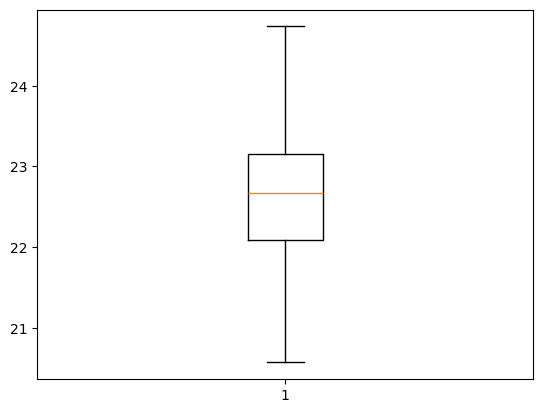

In [11]:
# Boxplot to confirm that all outliers are gone.
plt.boxplot(df['log_video_views'])
plt.show()

16.468752592994022 16.90199724044883 0.4332446474548064 15.818885621811813 17.551864211631038


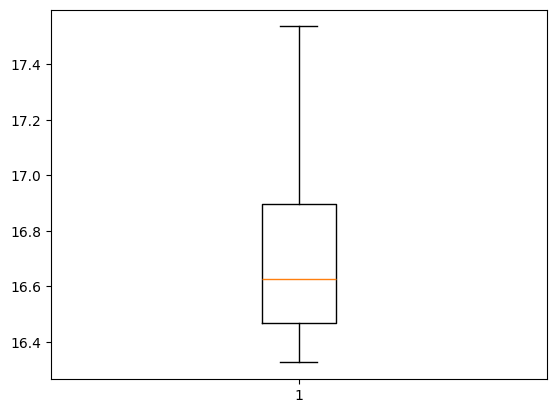

In [14]:
# Repeat the same process for subscribers.
q1 = df['log_subscribers'].quantile(0.25)
q3 = df['log_subscribers'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
print(q1, q3, iqr, lower_bound, upper_bound)

df = df.loc[(df['log_subscribers'] >= lower_bound) & (df['log_subscribers'] <= upper_bound)]

plt.boxplot(df['log_subscribers'])
plt.show()